## Import

In [32]:
import numpy as np
import seaborn as sb
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
%matplotlib inline
from sklearn.preprocessing import Normalizer, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

## Getting dataset

In [33]:
df = pd.read_csv('./SRC/titanic/train.csv', sep=',')
df_test = pd.read_csv('./SRC/titanic/test.csv', sep=',')
y_test = pd.read_csv('./SRC/titanic/gender_submission.csv', sep=',')

In [34]:
y_test = y_test['Survived']

## Data analisy

First step, delete irrelevant columns

In [35]:
df = df.drop(columns=['PassengerId', 'Name', 'Cabin'])
df_test = df_test.drop(columns=['PassengerId', 'Name', 'Cabin'])

Second step, plots to help analyze the dataset

<AxesSubplot:xlabel='Embarked', ylabel='count'>

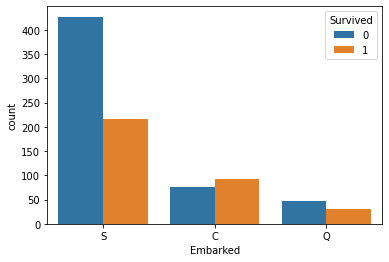

In [36]:
sb.countplot(data=df, x='Embarked', hue='Survived')

<AxesSubplot:xlabel='Pclass', ylabel='count'>

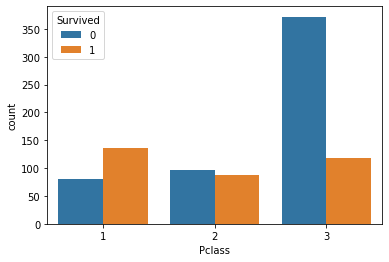

In [37]:
sb.countplot(data=df, x='Pclass', hue='Survived')

<AxesSubplot:xlabel='Sex', ylabel='count'>

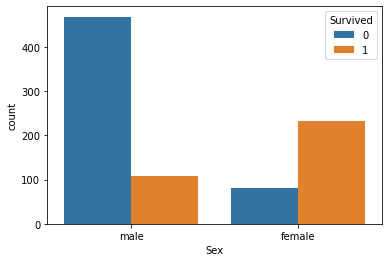

In [38]:
sb.countplot(data=df, x='Sex', hue='Survived')

After some of the analysis, I realized that some data is not as relevant (Fare, Ticket), some data is redundant (Embarked, the difference in the plot is due to some first class passengers boarding at a specific point) and finally the Cabin data are very important, but scarce.

## Data processing

In [39]:
df = df.drop(columns=['Embarked', 'Ticket', 'Fare'])
df_test = df_test.drop(columns=['Embarked', 'Fare', 'Ticket'])

In [40]:
df = df.fillna('0')
df_test = df_test.fillna('0')

In [41]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,male,22.0,1,0
1,1,1,female,38.0,1,0
2,1,3,female,26.0,0,0
3,1,1,female,35.0,1,0
4,0,3,male,35.0,0,0


In [42]:
labelencoder = LabelEncoder()

df['Sex'] = labelencoder.fit_transform(df['Sex'])
df_test['Sex'] = labelencoder.fit_transform(df_test['Sex'])

In [43]:
X_train, X_test = df.drop(columns=['Survived']), df_test
y_train = df['Survived']

In [44]:
y_test.head()

0    0
1    1
2    0
3    0
4    1
Name: Survived, dtype: int64

In [45]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch
0,3,1,34.5,0,0
1,3,0,47.0,1,0
2,2,1,62.0,0,0
3,3,1,27.0,0,0
4,3,0,22.0,1,1


## Training classifiers

### Selecting models and names

In [46]:
models = {
    'KNN': KNeighborsClassifier(),
    'Decision tree': DecisionTreeClassifier(),
    'Random forest': RandomForestClassifier(),
    'SVC': SVC(),
    'MLP': MLPClassifier(max_iter=4000),
    'Bayes': GaussianNB()
}

### Training

In [47]:
accuracies = []
classifiers = []
for i in models:
    clf = models[i].fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_predict)
    print(f'Accuracy {i} = {accuracy_score(y_test, y_predict)}')
    accuracies.append(accuracy)
    classifiers.append(i)

Accuracy KNN = 0.7918660287081339
Accuracy Decision tree = 0.7894736842105263
Accuracy Random forest = 0.8014354066985646
Accuracy SVC = 0.6363636363636364
Accuracy MLP = 0.9688995215311005
Accuracy Bayes = 0.868421052631579


### Plot results

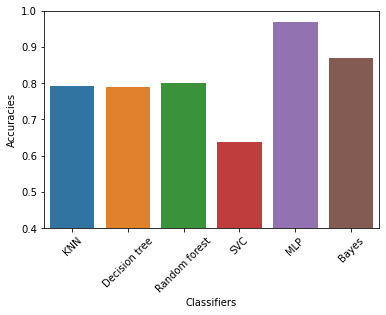

In [48]:
dataframe = pd.DataFrame({
    'Classifiers': classifiers,
    'Accuracies':accuracies
})
ax = sb.barplot(data=dataframe, x='Classifiers', y='Accuracies')
ax.set(ylim=(0.4,1))
ax.tick_params(axis='x', rotation=45)

## Improving classifier

### Selecting best classifiers

In [61]:
models = {
    'KNN': KNeighborsClassifier(),
    'Decision tree': DecisionTreeClassifier(),
    'Random forest': RandomForestClassifier(),
    'SVC Linear': SVC(kernel='linear'),
    'SVC Poly': SVC(kernel='poly', max_iter=40000),
    'MLP 1layer': MLPClassifier(max_iter=4000),
    'MLP 2layer': MLPClassifier(max_iter=4000),
}

In [50]:
C = [2 ** i for i in range(-5, 16,2)]
gamma = [2 ** i for i in range(-15, 4,2)]

In [51]:
estimators = [x for x in range(2,1000)]
params = {
    'KNN': {'n_neighbors':[1,3,5,7, 9, 11, 13, 15]},
    'Decision tree':{'criterion': ['gini','entropy'], 'splitter':['best', 'random']},
    'Random forest': {'criterion': ['gini','entropy'], 'n_estimators':estimators},
    'SVC Linear': {'degree':[3,4,5,6,7]},
    'SVC Poly': {'kernel':['poly'], 'degree':[2,3,4], 'C':C, 'gamma':gamma},
    'MLP 1layer': {'hidden_layer_sizes':[(i, ) for i in range(1000)]},
    'MLP 2layer': {'hidden_layer_sizes':[(random.randrange(0, 500), random.randrange(0, 500)) for i in range(1000)]}
}

### GridSearch to find the best classifiers and params

In [62]:
best_accuracy = 0

for i in models:
    clf = RandomizedSearchCV(models[i], params[i], n_iter=5).fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_predict)
    print(f'Accuracy {i} = {accuracy_score(y_test, y_predict)}')
    print(f'Best params {clf.best_params_}')
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_classifier = clf

Accuracy KNN = 0.7727272727272727
Best params {'n_neighbors': 7}
Accuracy Decision tree = 0.7966507177033493
Best params {'splitter': 'best', 'criterion': 'entropy'}


/home/geovabe/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Accuracy Random forest = 0.8157894736842105
Best params {'n_estimators': 200, 'criterion': 'entropy'}
Accuracy SVC Linear = 1.0
Best params {'degree': 3}


/home/geovabe/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=40000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/geovabe/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=40000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/geovabe/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=40000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/geovabe/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=40000).  Consider pre-processing your data with StandardScale

Accuracy SVC Poly = 0.6363636363636364
Best params {'kernel': 'poly', 'gamma': 3.0517578125e-05, 'degree': 2, 'C': 512}
Accuracy MLP 1layer = 0.9210526315789473
Best params {'hidden_layer_sizes': (861,)}
Accuracy MLP 2layer = 0.9425837320574163
Best params {'hidden_layer_sizes': (213, 231)}


## Checking whether normalization and standardization have an effect

In [53]:
X_train_normalized = Normalizer().fit(X_train).transform(X_train)
X_test_normalized = Normalizer().fit(X_train).transform(X_test)
X_train_standard = StandardScaler().fit(X_train).transform(X_train)
X_test_standard = StandardScaler().fit(X_test).transform(X_test)

In [54]:
classifiers = ['No alter', 'Normalized', 'Standarlized']
accuracies = []

model = best_classifier.best_estimator_
model.fit(X_train, y_train)
accuracies.append(accuracy_score(y_test, model.predict(X_test)))

model = best_classifier.best_estimator_
model.fit(X_train_normalized, y_train)
accuracies.append(accuracy_score(y_test, model.predict(X_test_normalized)))


model = best_classifier.best_estimator_
model.fit(X_train_standard,y_train)
accuracies.append(accuracy_score(y_test, model.predict(X_test_standard)))

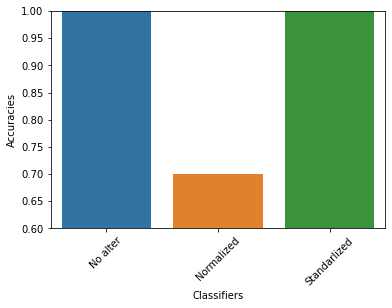

In [55]:
dataframe = pd.DataFrame({
    'Classifiers': classifiers,
    'Accuracies':accuracies
})
ax = sb.barplot(data=dataframe, x='Classifiers', y='Accuracies')
ax.set(ylim=(0.6,1))
ax.tick_params(axis='x', rotation=45)

Normalization and standardization did not bring better results, so the best classifier is trained by the unaltered dataset

## Saving best model

In [56]:
import os
save_models_path = './results'
if not os.path.exists(save_models_path):
    os.mkdir(save_models_path)

In [57]:
import joblib
import glob

In [58]:
filename = save_models_path+'/titanic.pkl'
model = best_classifier.best_estimator_
model.fit(X_train, y_train)
joblib.dump(model,filename)

['./results/titanic.pkl']

No alter data was chosen to implement the algorithm, as it has better results in the tests.

In [59]:
model_load = joblib.load('./results/titanic.pkl')

In [60]:
accuracy_score(y_test, model_load.predict(X_test))

1.0